# **Target Trial Emulation**

C:\Users\meizi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


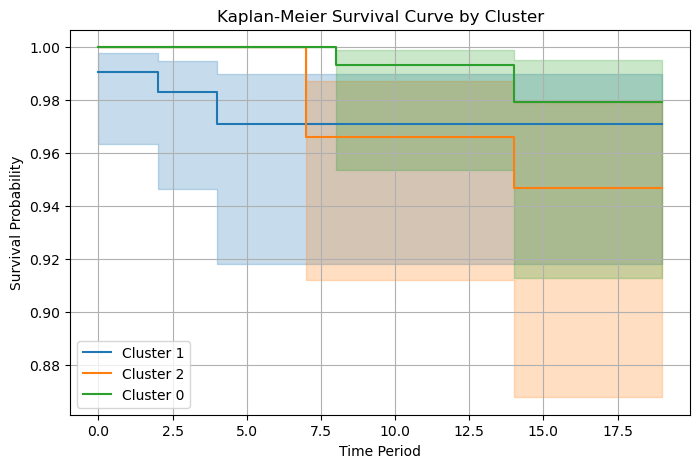

ConvergenceError: Convergence halted due to matrix inversion problems. Suspicion is high collinearity. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-modelMatrix is singular.

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, CoxPHFitter
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Install missing dependencies
try:
    import lifelines
except ImportError:
    import sys
    !{sys.executable} -m pip install lifelines

# Load the dataset
df = pd.read_csv("data_censored.csv")

# Ensure necessary columns exist
required_columns = ['period', 'outcome', 'treatment', 'x1', 'x2', 'x3', 'x4', 'age', 'age_s']
missing_columns = [col for col in required_columns if col not in df.columns]
if missing_columns:
    raise ValueError(f"Missing columns in dataset: {missing_columns}")

# Feature selection for clustering
features = ['x1', 'x2', 'x3', 'x4', 'age', 'age_s']
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[features])

# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(df_scaled)

# Kaplan-Meier Estimator per cluster
kmf = KaplanMeierFitter()
plt.figure(figsize=(8, 5))
for cluster in df['cluster'].unique():
    cluster_data = df[df['cluster'] == cluster]
    kmf.fit(durations=cluster_data['period'], event_observed=cluster_data['outcome'], label=f'Cluster {cluster}')
    kmf.plot_survival_function()

plt.title("Kaplan-Meier Survival Curve by Cluster")
plt.xlabel("Time Period")
plt.ylabel("Survival Probability")
plt.grid()
plt.show()

# Cox Proportional Hazards Model with Clusters
cph = CoxPHFitter()
cph.fit(df[['period', 'treatment', 'x1', 'x2', 'x3', 'x4', 'age', 'age_s', 'outcome', 'cluster']], duration_col='period', event_col='outcome')

# Print summary of Cox model
cph.print_summary()

# Plot Cox model coefficients
plt.figure(figsize=(8, 5))
cph.plot()
plt.title("Cox Proportional Hazards Model Coefficients with Clusters")
plt.grid()
plt.show()
